In [34]:
import openeo
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support#, ConfusionMatrixDisplay
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
# from explore import all_crop_codes
import math
import numpy as np
from pathlib import Path
import json

In [8]:
all_crop_codes

{0: 'Unknown',
 991: 'NaN',
 1000: 'Cereals',
 1100: 'Wheat',
 1110: 'Winter wheat',
 1120: 'Spring wheat',
 1200: 'Maize',
 1300: 'Rice',
 1400: 'Sorghum',
 1500: 'Barley',
 1510: 'Winter barley',
 1520: 'Spring barley',
 1600: 'Rye',
 1610: 'Winter rye',
 1620: 'Spring rye',
 1700: 'Oats',
 1800: 'Millets',
 1900: 'Other cereals',
 1910: 'Winter cereal',
 1920: 'Spring cereal',
 2000: 'Vegetables and melons',
 2100: 'Leafy or stem vegetables',
 2110: 'Artichokes',
 2120: 'Asparagus',
 2130: 'Cabages',
 2140: 'Cauliflowers & brocoli',
 2150: 'Lettuce',
 2160: 'Spinach',
 2170: 'Chicory',
 2190: 'Other leafy/stem vegetables',
 2200: 'Fruit-bearing vegetables',
 2210: 'Cucumbers',
 2220: 'Eggplants',
 2230: 'Tomatoes',
 2240: 'Watermelons',
 2250: 'Cantaloupes and other melons',
 2260: 'Pumpkin, squash and gourds',
 2290: 'Other fruit-bearing vegetables',
 2300: 'Root, bulb or tuberous vegetables',
 2310: 'Carrots',
 2320: 'Turnips',
 2330: 'Garlic',
 2340: 'Onions and shallots',
 2350:

In [28]:
df = pd.read_csv("resources/training_data/final_feats.csv",index_col=0).drop_duplicates()
df = df[~df["B06_p50"].isnull()]
df

,id,B06_p25,B06_p50,B06_p75,B06_sd,B06_t4,B06_t7,B06_t10,B06_t13,B06_t16,...,VH_p75,VH_sd,VH_t2,VH_t5,VH_t8,VH_t11,VH_t14,VH_t17,groupID,zoneID
0,1110,9104.0,10966.0,11666.0,2046.0,9566.0,11332.0,7297.0,8296.0,11148.0,...,12894.0,85.0,10668.0,11305.0,12745.0,9634.0,12859.0,13863.0,46000.0,46172.0
1,1110,9227.0,9948.0,10807.0,891.0,10162.0,9900.0,10046.0,9534.0,9022.0,...,12368.0,60.0,10945.0,8646.0,12882.0,10935.0,12198.0,14887.0,46000.0,46172.0
2,1110,8771.0,9431.0,10428.0,994.0,10104.0,9431.0,10640.0,9645.0,8651.0,...,11920.0,222.0,8715.0,6851.0,11830.0,12813.0,12114.0,9180.0,46000.0,46172.0
3,1110,6880.0,8516.0,10473.0,1898.0,12176.0,9281.0,5913.0,7350.0,7083.0,...,11546.0,192.0,12142.0,6541.0,11962.0,8029.0,9667.0,11431.0,46000.0,46172.0
4,1110,8931.0,9633.0,10908.0,2969.0,8883.0,9783.0,7372.0,9140.0,10908.0,...,11921.0,237.0,9686.0,7887.0,12980.0,6597.0,11090.0,14204.0,46000.0,46172.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34214,9213,7212.0,8692.0,9813.0,3108.0,8907.0,16331.0,8692.0,8122.0,4496.0,...,18624.0,138.0,17013.0,14453.0,14363.0,13925.0,14626.0,20596.0,46000.0,46172.0
34215,9213,6898.0,8220.0,9225.0,3238.0,8019.0,16410.0,8928.0,8055.0,4102.0,...,18247.0,197.0,17461.0,17213.0,16267.0,16688.0,14573.0,19747.0,46000.0,46172.0
34216,9213,7517.0,8782.0,9834.0,2850.0,8950.0,15660.0,9003.0,8291.0,5055.0,...,18309.0,232.0,17374.0,14314.0,14827.0,16760.0,15941.0,22053.0,46000.0,46172.0
34217,9213,8737.0,10419.0,12449.0,2614.0,10481.0,15236.0,11701.0,10102.0,8737.0,...,15085.0,143.0,13997.0,13282.0,12933.0,12653.0,13846.0,19930.0,46000.0,46172.0


In [4]:
pd.options.display.max_rows = 999
df.groupby("id").count()

#1110, 1510, 1910, # "Winter wheat", "Winter barley", "Winter cereal", # Winter cereals
#1120, 1520, 1920, #"Spring wheat", "Spring barley", "Spring cereal", # Spring / summer cereals
#4351, 1200, 5100, 8100, #"Winter rapeseed", "Maize", "Potatoes", "Sugar beet",
#9100, 9110, 9120, # "Grasses and other fodder crops", "Temporary grass crops", "Permanent grass crops" # Grasses

## Winter wheat: 2746 samples (1110)
## Spring wheat: 91 samples (1120)
## Winter barley: 2423 samples (1510)
## Spring barley: 1119 samples (1520)
## Winter cereal: 1078 samples (1910)
## Spring cereal: 299 samples (1920)
## Maize: 2937 samples (1200)
## Winter rapeseed: 633 (4351)
## Potatoes: 1942 samples (5100)
## Sugar beet: 1223 samples (8100)
## Grass 1206, 1163, 776 samples (9100, 9110, 9120)

,B06_p25,B06_p50,B06_p75,B06_sd,B06_t4,B06_t7,B06_t10,B06_t13,B06_t16,B06_t19,...,VH_p75,VH_sd,VH_t2,VH_t5,VH_t8,VH_t11,VH_t14,VH_t17,groupID,zoneID
id,,,,,,,,,,,,,,,,,,,,,
0,1670,1670,1670,1667,1624,1655,1661,1659,1657,1625,...,1670,1670,1670,1670,1670,1670,1670,1670,1670,1670
991,11,11,11,11,11,11,11,11,11,8,...,11,11,11,11,11,11,11,11,11,11
1100,552,552,552,552,551,552,552,552,552,547,...,552,552,552,552,552,552,552,552,552,552
1110,2746,2746,2746,2746,2746,2746,2746,2746,2746,2590,...,2746,2746,2746,2746,2746,2746,2746,2746,2746,2746
1120,91,91,91,91,91,91,91,91,91,88,...,91,91,91,91,91,91,91,91,91,91
1200,2937,2937,2937,2937,2936,2936,2937,2935,2934,2733,...,2937,2937,2937,2937,2937,2937,2937,2937,2937,2937
1300,128,128,128,128,128,128,128,128,128,123,...,128,128,128,128,128,128,128,128,128,128
1400,174,174,174,174,174,174,174,174,174,169,...,174,174,174,174,174,174,174,174,174,174
1500,542,542,542,541,537,541,541,540,540,533,...,542,542,542,542,542,542,542,542,542,542


In [29]:
base_feats_s2 = ["p25", "p50", "p75", "sd", "t4", "t7", "t10", "t13", "t16", "t19"]
base_layers_s2 = ["B06", "B12", "NDVI", "NDMI", "NDGI", "NDRE1", "NDRE2", "NDRE5", "ANIR"]
base_feats_s1 = ["p25", "p50", "p75", "sd", "t2", "t5", "t8", "t11", "t14", "t17"]
base_layers_s1 = ["ratio", "VH", "VV"]
feat_names_s2 = [i+"_"+j for i in base_layers_s2 for j in base_feats_s2]
feat_names_s1 = [i+"_"+j for i in base_layers_s1 for j in base_feats_s1]
all_bands = feat_names_s2 + feat_names_s1

In [30]:
def train_classifier(X,y,param_grid,output_path):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=190)

        cb = CatBoostClassifier()

        grid_search = GridSearchCV(estimator = cb, param_grid = param_grid, cv = 3, n_jobs = -1)

        grid_search.fit(X_train, y_train)
        gs_results = pd.DataFrame(grid_search.cv_results_).sort_values(by=["mean_test_score"],axis=0,ascending=False)
        print(gs_results)

        print(grid_search.best_estimator_)

        y_pred = grid_search.predict(X_test)

        grid_search.best_estimator_.save_model(fname=str(output_path / "model.cbm"))

        feat_imp = sorted(dict(zip(all_bands,grid_search.best_estimator_.get_feature_importance())).items(), key=lambda x: x[1], reverse=True)
        # feat_imp.sort(key = lambda row: row[1], reverse=True)
        feat_imp_df = pd.DataFrame(feat_imp)
        feat_imp_df.columns = ["band", "importance"]
        print("Most important features: ")
        print(feat_imp_df.head())
        clean_feat = feat_imp_df[feat_imp_df["importance"] != 0]
        plt.bar(clean_feat["band"],clean_feat["importance"])
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.savefig(str(output_path / "feature_importance.png"))

        acc = accuracy_score(y_test,y_pred)
        print("Accuracy on test set: "+str(acc)[0:5])
        prec, rec, fscore, sup = precision_recall_fscore_support(y_test,y_pred)
        print(prec,rec,fscore,sup)
#         ConfusionMatrixDisplay.from_predictions(y_test, y_pred,xticks_rotation=90)
#         plt.tight_layout()
#         plt.savefig(str(output_path / "confusion_matrix.png"))

        final_res = {
                "feat_importance": feat_imp,
                "accuracy": acc,
                "precision": prec.tolist(),
                "recall": rec.tolist(),
                "fscore": fscore.tolist(),
                "support": sup.tolist()
        }
        with open(str(output_path / "final_results.json"), "w") as outfile:
            json.dump(final_res, outfile, indent = 4) 


In [31]:
def winter_spring_grouped(x):
    ## Winter wheat: 2746 samples (1110)
    ## Spring wheat: 91 samples (1120)
    ## Winter barley: 2423 samples (1510)
    ## Spring barley: 1119 samples (1520)
    ## Winter cereal: 1078 samples (1910)
    ## Spring cereal: 299 samples (1920)
    ## Maize: 2937 samples (1200)
    ## Winter rapeseed: 633 (4351)
    ## Potatoes: 1942 samples (5100)
    ## Sugar beet: 1223 samples (8100)
    ## Grass 1206, 1163, 776 samples (9100, 9110, 9120)
    if x == 1100 or x == 1110 or x == 1120: #WHEAT
        return 1100
    elif x == 1500 or x == 1510 or x == 1520: #BARLEY
        return 1500
    elif x == 1900 or x == 1910 or x == 1920: #CEREAL
        return 1900
    elif x == 1200:
        return 1200
    elif x == 4350 or x == 4351 or x == 4352: #RAPESEED
        return 4350
    elif x == 5100:
        return 5100
    elif x == 8100:
        return 8100
    elif x == 9100 or x == 9110 or x == 9120:
        return 9100
    else:
        return 0
    
df_ws_grouped = df.copy()
df_ws_grouped = df_ws_grouped[~df_ws_grouped["id"].isin([0, 1000, 991, 9998])]
df_ws_grouped["y1"] = df_ws_grouped["id"].apply(winter_spring_grouped)

In [35]:
out_path = Path.cwd() / "resources" / "model_training" / "y1"
out_path.mkdir(parents=True, exist_ok=True)

## Model training
X = df_ws_grouped[all_bands]
y = df_ws_grouped["y1"]

0:	learn: 2.0311210	total: 414ms	remaining: 13m 46s
1:	learn: 1.9017548	total: 2.35s	remaining: 39m 3s
2:	learn: 1.7989712	total: 2.88s	remaining: 31m 58s
3:	learn: 1.7169141	total: 3.35s	remaining: 27m 51s
4:	learn: 1.6486676	total: 3.9s	remaining: 25m 57s
5:	learn: 1.5878873	total: 4.28s	remaining: 23m 41s
6:	learn: 1.5340521	total: 4.61s	remaining: 21m 53s
7:	learn: 1.4897426	total: 4.7s	remaining: 19m 30s
8:	learn: 1.4487733	total: 4.78s	remaining: 17m 37s
9:	learn: 1.4103645	total: 4.85s	remaining: 16m 4s
10:	learn: 1.3774402	total: 4.92s	remaining: 14m 48s
11:	learn: 1.3455340	total: 4.98s	remaining: 13m 45s
12:	learn: 1.3161355	total: 5.05s	remaining: 12m 51s
13:	learn: 1.2908043	total: 5.11s	remaining: 12m 5s
14:	learn: 1.2661360	total: 5.18s	remaining: 11m 25s
15:	learn: 1.2454463	total: 5.25s	remaining: 10m 50s
16:	learn: 1.2246762	total: 5.32s	remaining: 10m 20s
17:	learn: 1.2043278	total: 5.38s	remaining: 9m 52s
18:	learn: 1.1874166	total: 5.45s	remaining: 9m 28s
19:	learn:

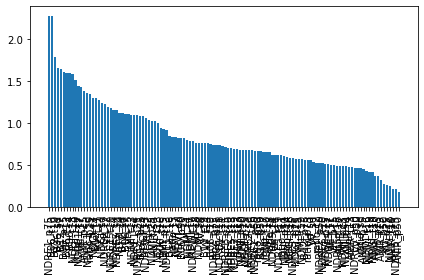

In [36]:
param_grid = {'learning_rate': [0.07],#[0.03, 0.1],
        'depth': [7],
        'l2_leaf_reg': [1], #, 5, 10 lijkt niet echt te boeien ?
        'iterations': [2000]}
train_classifier(X,y,param_grid,out_path)